## Class specificity of MultiPEC-identified networks.

Import dependencies and define paths.

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def find_repo_root(marker="setup.py"):
    path = Path.cwd()
    while not (path / marker).exists() and path != path.parent:
        path = path.parent
    return path

project_root = find_repo_root()

data_dir = project_root/"data/results/cnn/"
figures_folder = project_root/"data/figures/cnn/"

# List of pruning range identifiers
variants = ["4down", "34", "23", "12", "05median", "05up"]
base_filename = "pruned_{}.xlsx"

Define class specificity functions.

In [ ]:
# Specificity metrics
def compute_max_mean(df):
    delta_cols = [col for col in df.columns if col.startswith("Δ")]
    max_val = df[delta_cols].abs().max(axis=1)
    mean_val = df[delta_cols].abs().mean(axis=1)
    specificity = max_val - mean_val
    return specificity

def compute_top2_ratio(df):
    delta_cols = [col for col in df.columns if col.startswith("Δ")]
    sorted_abs = df[delta_cols].abs().apply(lambda row: sorted(row, reverse=True), axis=1)
    return sorted_abs.apply(lambda x: x[0] / (x[1] + 1e-8))


Visualize distribution of class specificity (`compute_max_mean`) across PEC ranges.

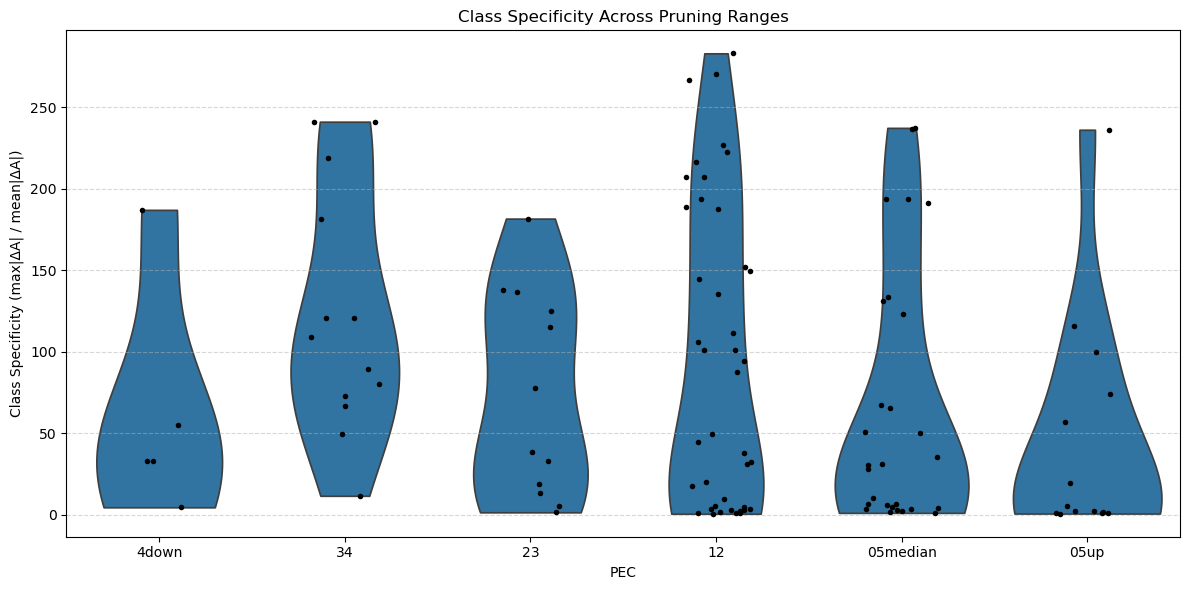

In [ ]:
# Container for class specificity values
specificity_records = []

# Loop through each file
for variant in variants:
    file_path = os.path.join(data_dir, base_filename.format(variant))
    if not os.path.exists(file_path):
        print(f"Warning: File not found: {file_path}")
        continue

    df = pd.read_excel(file_path)
    df = df.iloc[1:]  # Drop the first row of data (keep headers)
    class_specificity = compute_max_mean(df)

    for value in class_specificity:
        specificity_records.append({
            "PEC": variant,
            "Class Specificity": value
        })

specificity_df = pd.DataFrame(specificity_records)

# Plot
plt.figure(figsize=(12, 6))
sns.violinplot(x="PEC", y="Class Specificity", data=specificity_df, inner=None, cut=0)
sns.stripplot(x="PEC", y="Class Specificity", data=specificity_df, color="black", size=4, jitter=0.2)

plt.title("Class Specificity Across Pruning Ranges")
plt.ylabel("Class Specificity (max|ΔA| - mean|ΔA|)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Define helper functions for extracting data for plotting.

In [ ]:
# PEC extractor
def extract_pec(subnet_str):
    try:
        floats = re.findall(r"[-+]?\d*\.\d+|\d+", subnet_str)
        return float(floats[-1]) if floats else None
    except Exception:
        return None

# Node pair PEC extractor
def extract_pair_pec(subnet_str):
    try:
        # Match only floats (e.g., 0.05, 1.23e-4)
        floats = re.findall(r"[-+]?\d*\.\d+(?:[eE][-+]?\d+)?", subnet_str)
        return float(floats[0]) if floats else None
    except Exception:
        return None
    
# Net extractor
def extract_net(subnet_str):
    match = re.match(r"\(\((.*?)\),", subnet_str)
    if match:
        tuple_str = match.group(1)
        return tuple(map(int, tuple_str.split(',')))
    return None

# Specific class
def extract_specific_class(df):
    delta_cols = [col for col in df.columns if col.startswith("Δ")]
    max_class = df[delta_cols].abs().idxmax(axis=1)
    return max_class.str.replace("Δ", "", regex=False)

def extract_specific_class_delta(df):
    delta_cols = [col for col in df.columns if col.startswith("Δ")]
    max_val = df[delta_cols].abs().max(axis=1)
    return max_val


Visualize the relationship between class specificity and PEC.


=== Dependency Stats for MaxMean ===
Pearson: -0.2223, p = 1.80e-02
Spearman: -0.2999, p = 1.25e-03
Mutual Info: 0.0000
Linear R²: 0.0494
Quadratic R²: 0.0583


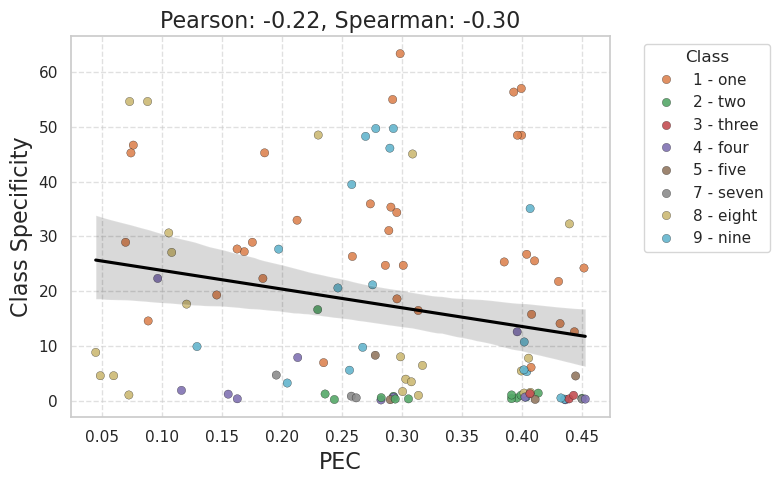

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import pearsonr, spearmanr


# Data aggregation
records = []

for variant in variants:
    file_path = data_dir / base_filename.format(variant)
    if not file_path.exists():
        print(f"File not found: {file_path}")
        continue

    df = pd.read_excel(file_path)
    df = df.iloc[1:]

    df["ClassSpec_MaxMean"] = compute_max_mean(df)
    df["ClassSpec_Top2"] = compute_top2_ratio(df)

    df["PEC"] = df["Subnet"].astype(str).apply(extract_pec)
    df["PairPEC"] = df["Subnet"].astype(str).apply(extract_pair_pec)

    df["Net"] = df["Subnet"].astype(str).apply(extract_net)
    df["Class"] = extract_specific_class(df)
    df["ClassDelta"] = extract_specific_class_delta(df)

    for _, row in df.iterrows():
        if pd.notna(row["PEC"]):
            records.append({
                "PEC": row["PEC"],
                "PairPEC": row["PairPEC"],
                "MaxMean": row["ClassSpec_MaxMean"],
                "Top2": row["ClassSpec_Top2"],
                "Net": row["Net"],
                "NetSize": len(row["Net"]) if isinstance(row["Net"], tuple) else None,
                "Class": row["Class"],
                "ClassDelta": row["ClassDelta"]
            })

plot_df = pd.DataFrame(records)
plot_df.to_excel(data_dir / "pec_class_specificity_data.xlsx", index=False)
# Choose metric
metric = "MaxMean"  # Change to MaxMean, Top2 as needed

# Prepare data
plot_df['Class'] = plot_df['Class'].astype(str)
plot_df = plot_df.dropna(subset=['PEC', metric, 'Class'])

# Extract numeric part of class label for ordering
plot_df['ClassNum'] = plot_df['Class'].str.extract(r'^(\d+)').astype(int)
ordered_classes = plot_df.sort_values('ClassNum')['Class'].unique().tolist()

# Build palette
palette = sns.color_palette()
colors = [palette[i] for i in range(1, 6)] + [palette[i] for i in range(7, 10)]
class_color_map = dict(zip(ordered_classes, colors))

# Prepare X and y
X = plot_df[['PEC']].values
y = plot_df[metric].values

# Plot
plt.figure(figsize=(8, 5))

# Color-coded scatter by class
scatter = sns.scatterplot(
    data=plot_df,
    x="PEC",
    y=metric,
    hue="Class",
    palette=class_color_map,
    alpha=0.9,
    edgecolor="black",
    linewidth=0.2
)

# Get handles and labels
handles, labels = scatter.get_legend_handles_labels()
label_to_handle = dict(zip(labels, handles))
sorted_handles = [label_to_handle[label] for label in ordered_classes if label in label_to_handle]

# OPTIONAL:
# LOWESS smoothing
smoothed = lowess(y, X.flatten(), frac=0.3)
# plt.plot(smoothed[:, 0], smoothed[:, 1], color="orange", label="LOWESS")

# Quadratic fit
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
model_quad = LinearRegression().fit(X_poly, y)
y_quad = model_quad.predict(X_poly)
# plt.plot(X, y_quad, color="red", label="Quadratic Fit")

# Linear fit
model_lin = LinearRegression().fit(X, y)
y_lin = model_lin.predict(X)
# plt.plot(X, y_lin, color="blue", linestyle="--", label="Linear Fit")
sns.regplot(x=plot_df["PEC"], y=plot_df[metric], scatter=False, color="black")

# Stats
pear, p_pear = pearsonr(plot_df["PEC"], plot_df[metric])
spear, p_spear = spearmanr(plot_df["PEC"], plot_df[metric])
mi = mutual_info_regression(X, y, discrete_features=False)
r2_quad = r2_score(y, y_quad)
r2_lin = r2_score(y, y_lin)

print(f"\n=== Dependency Stats for {metric} ===")
print(f"Pearson: {pear:.4f}, p = {p_pear:.2e}")
print(f"Spearman: {spear:.4f}, p = {p_spear:.2e}")
print(f"Mutual Info: {mi[0]:.4f}")
print(f"Linear R²: {r2_lin:.4f}")
print(f"Quadratic R²: {r2_quad:.4f}")

plt.xlabel("PEC", fontsize=16)
plt.ylabel("Class Specificity", fontsize=16)
plt.title(f"Pearson: {pear:.2f}, Spearman: {spear:.2f}", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.6)

plt.legend(
    sorted_handles,
    ordered_classes,
    title='Class',
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.tight_layout()
save_path = figures_folder / f"pec_vs_class_specificity_{metric.lower()}.png"
plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()


Show networks with the highest class specificity score per class.

In [7]:
def extract_class_specific_nets(df, metric="MaxMean"):
    # Group by 'Class' and find row with max metric in each group
    idx = df.groupby('Class')[metric].idxmax()
    # Return the rows corresponding to those max metric values
    return df.loc[idx][['Class', 'Net', 'PEC', metric]]

# Extract MaxMean class-specific nets
max_mean_subnet_df = extract_class_specific_nets(plot_df, metric="MaxMean")

print("\nMax Mean Subnet per Class")
print(max_mean_subnet_df)



Max Mean Subnet per Class
        Class                                  Net       PEC    MaxMean
45    1 - one                        (20, 8, 9, 6)  0.298629  63.327534
29    2 - two               (7, 6, 9, 4, 24, 5, 0)  0.229901  16.665190
96  3 - three                          (0, 12, 21)  0.406761   1.334984
12   4 - four                         (6, 5, 9, 2)  0.096591  22.349010
44   5 - five                        (0, 9, 1, 18)  0.277894   8.334732
20  7 - seven  (12, 24, 2, 25, 18, 3, 7, 11, 6, 9)  0.195403   4.728566
8   8 - eight                   (4, 2, 9, 6, 3, 5)  0.073196  54.599807
49   9 - nine         (0, 5, 9, 29, 4, 7, 8, 2, 3)  0.278299  49.677487


Visualize the relationship between PEC value of the node-pair seed and the network PEC. 

Pearson correlation: 0.9931
P-value: 3.0918e-105


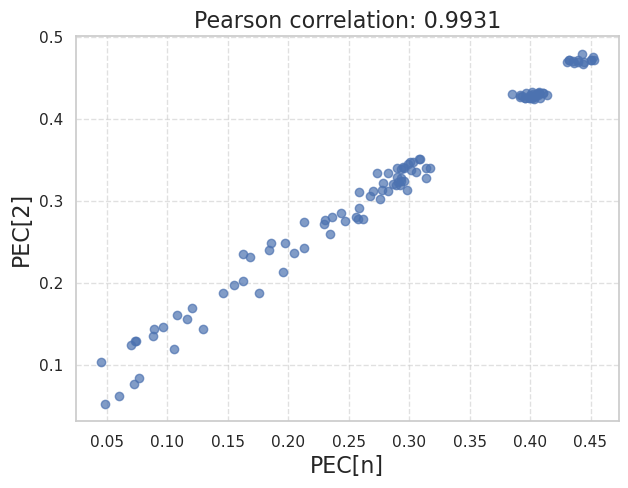

In [8]:
sns.set(style="whitegrid")

# Pearson correlation
corr, p_value = pearsonr(plot_df['PEC'], plot_df['PairPEC'])
print(f"Pearson correlation: {corr:.4f}")
print(f"P-value: {p_value:.4e}")

# Scatter plot: PairPEC vs PEC
plt.figure(figsize=(7, 5))
plt.scatter(plot_df['PEC'], plot_df['PairPEC'], alpha=0.7)
plt.xlabel('PEC[n]', fontsize=16)
plt.ylabel('PEC[2]', fontsize=16)
plt.title(f"Pearson correlation: {corr:.4f}", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig(figures_folder / "pec_pairpec_scatter.png", bbox_inches='tight', dpi=300)
plt.show()




Visualize the relationship between the maximum accuracy change post-pruning and and the number of pruned nodes, for MultiPEC-identified networks.

6.08247190030336e-08 3.3646600973732804e-09


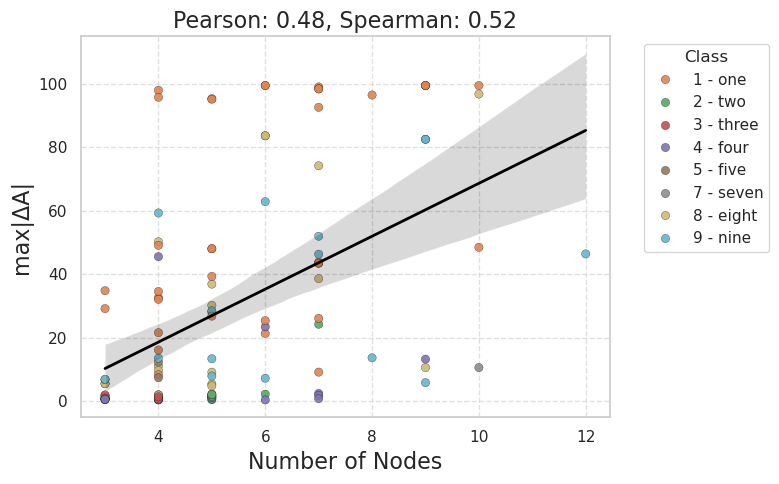

In [9]:
sns.set(style="whitegrid")
# Ensure numeric
plot_df['ClassDelta'] = pd.to_numeric(plot_df['ClassDelta'], errors='coerce')
plot_df['NetSize'] = pd.to_numeric(plot_df['NetSize'], errors='coerce')

# Drop NaNs
plot_df = plot_df.dropna(subset=['ClassDelta', 'NetSize', 'Class'])

# Extract numeric class prefix to sort (e.g., '0 - zero' -> 0)
plot_df['ClassNum'] = plot_df['Class'].str.extract(r'^(\d+)').astype(int)
ordered_classes = plot_df.sort_values('ClassNum')['Class'].unique().tolist()

# Custom palette skipping color index 0 and 6
palette = sns.color_palette()
colors = [palette[i] for i in range(1, 6)] + [palette[i] for i in range(7, 10)]
class_color_map = dict(zip(ordered_classes, colors))

# Calculate correlations
pearson_corr, pp = pearsonr(plot_df['NetSize'], plot_df['ClassDelta'])
spearman_corr, sp = spearmanr(plot_df['NetSize'], plot_df['ClassDelta'])
print(pp, sp)

# Plot: Regression without outliers, color-coded by class
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=plot_df,
    x='NetSize',
    y='ClassDelta',
    hue='Class',
    palette=class_color_map,
    alpha=0.9,
    edgecolor='black',
    linewidth=0.2
)

# Add regression line (fitted on all data)
sns.regplot(
    data=plot_df,
    x='NetSize',
    y='ClassDelta',
    scatter=False,
    color='black',
    line_kws={'linewidth': 2}
)

# Add correlations to title
plt.title(
    f"Pearson: {pearson_corr:.2f}, Spearman: {spearman_corr:.2f}",
    fontsize=16
)
plt.xlabel("Number of Nodes", fontsize=16)
plt.ylabel("max|ΔA|", fontsize=16)
plt.legend(
    sorted_handles,
    ordered_classes,
    title='Class',
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.tight_layout()
plt.grid(True, linestyle="--", alpha=0.6)

plt.savefig(figures_folder / "delta_size_regression.png", bbox_inches='tight', dpi=300)
plt.show()
